# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    num_workers = 0
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor()])

    
    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(data_dir, transform)

    # create and return DataLoaders
    data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 24
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

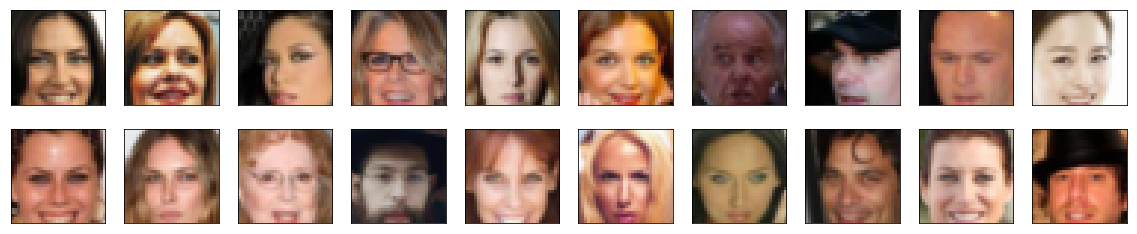

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
        # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2 out
        
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # all hidden layers + leaky relu activation
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim*8*2*2)
        
        # final output layer
        x = self.fc(x)   
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)    
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        
        x=F.relu(self.t_conv1(x))
        x=F.relu(self.t_conv2(x))
        x=F.relu(self.t_conv3(x))
        x=torch.tanh(self.t_conv4(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
        
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):

        m.weight.data.normal_(0.0, 0.02)
        

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fal

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)

    labels = torch.ones(batch_size) * 0.9 # real labels = 0.9 with smoothing
        
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# params
lr = 0.0005
beta1=0.2
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])



---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()


            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   25] | d_loss: 1.4217 | g_loss: 2.3973
Epoch [    1/   25] | d_loss: 1.3932 | g_loss: 2.5837
Epoch [    1/   25] | d_loss: 1.4002 | g_loss: 2.5626
Epoch [    1/   25] | d_loss: 1.4289 | g_loss: 1.7713
Epoch [    1/   25] | d_loss: 1.1306 | g_loss: 1.5513
Epoch [    1/   25] | d_loss: 1.3210 | g_loss: 1.2498
Epoch [    1/   25] | d_loss: 1.0961 | g_loss: 1.2287
Epoch [    1/   25] | d_loss: 1.5728 | g_loss: 1.8142
Epoch [    1/   25] | d_loss: 1.3014 | g_loss: 1.2474
Epoch [    1/   25] | d_loss: 1.1644 | g_loss: 1.5424
Epoch [    1/   25] | d_loss: 1.3244 | g_loss: 1.1951
Epoch [    1/   25] | d_loss: 1.1766 | g_loss: 1.3852
Epoch [    1/   25] | d_loss: 1.2792 | g_loss: 2.0556
Epoch [    1/   25] | d_loss: 1.4360 | g_loss: 1.8205
Epoch [    1/   25] | d_loss: 1.1846 | g_loss: 1.3388
Epoch [    1/   25] | d_loss: 1.2044 | g_loss: 1.9879
Epoch [    1/   25] | d_loss: 1.3590 | g_loss: 1.0452
Epoch [    1/   25] | d_loss: 1.1558 | g_loss: 1.6932
Epoch [    1/   25] | d_loss

Epoch [    3/   25] | d_loss: 1.0545 | g_loss: 1.9976
Epoch [    3/   25] | d_loss: 1.0646 | g_loss: 2.2521
Epoch [    3/   25] | d_loss: 1.2105 | g_loss: 1.0145
Epoch [    3/   25] | d_loss: 0.8490 | g_loss: 1.7432
Epoch [    3/   25] | d_loss: 1.1613 | g_loss: 1.9696
Epoch [    3/   25] | d_loss: 0.8658 | g_loss: 1.6871
Epoch [    3/   25] | d_loss: 1.2170 | g_loss: 0.6341
Epoch [    3/   25] | d_loss: 0.9254 | g_loss: 1.4436
Epoch [    3/   25] | d_loss: 0.8870 | g_loss: 1.2097
Epoch [    3/   25] | d_loss: 1.0675 | g_loss: 1.1186
Epoch [    3/   25] | d_loss: 0.9224 | g_loss: 1.7429
Epoch [    3/   25] | d_loss: 0.9416 | g_loss: 0.9412
Epoch [    3/   25] | d_loss: 1.1359 | g_loss: 0.8074
Epoch [    3/   25] | d_loss: 0.9987 | g_loss: 2.3052
Epoch [    3/   25] | d_loss: 1.2225 | g_loss: 1.2556
Epoch [    3/   25] | d_loss: 1.3782 | g_loss: 2.6259
Epoch [    3/   25] | d_loss: 0.7978 | g_loss: 1.3646
Epoch [    3/   25] | d_loss: 1.1003 | g_loss: 1.9983
Epoch [    3/   25] | d_loss

Epoch [    5/   25] | d_loss: 0.7687 | g_loss: 1.4790
Epoch [    5/   25] | d_loss: 0.8888 | g_loss: 1.6428
Epoch [    5/   25] | d_loss: 0.9437 | g_loss: 1.0048
Epoch [    5/   25] | d_loss: 0.8743 | g_loss: 1.6690
Epoch [    5/   25] | d_loss: 0.8494 | g_loss: 2.3166
Epoch [    5/   25] | d_loss: 0.6946 | g_loss: 2.4415
Epoch [    5/   25] | d_loss: 1.3369 | g_loss: 2.5856
Epoch [    5/   25] | d_loss: 0.6709 | g_loss: 1.7041
Epoch [    5/   25] | d_loss: 1.0444 | g_loss: 1.4313
Epoch [    5/   25] | d_loss: 0.9080 | g_loss: 1.5681
Epoch [    5/   25] | d_loss: 0.8561 | g_loss: 0.9155
Epoch [    5/   25] | d_loss: 0.9628 | g_loss: 2.8967
Epoch [    5/   25] | d_loss: 0.6926 | g_loss: 2.0555
Epoch [    5/   25] | d_loss: 1.0956 | g_loss: 1.3911
Epoch [    5/   25] | d_loss: 1.1154 | g_loss: 1.7147
Epoch [    5/   25] | d_loss: 0.9397 | g_loss: 3.5432
Epoch [    5/   25] | d_loss: 0.9620 | g_loss: 1.9016
Epoch [    5/   25] | d_loss: 0.6043 | g_loss: 1.6661
Epoch [    5/   25] | d_loss

Epoch [    7/   25] | d_loss: 0.5349 | g_loss: 2.1525
Epoch [    7/   25] | d_loss: 0.9105 | g_loss: 1.6146
Epoch [    7/   25] | d_loss: 0.8131 | g_loss: 2.0247
Epoch [    7/   25] | d_loss: 0.8106 | g_loss: 2.1702
Epoch [    7/   25] | d_loss: 0.6639 | g_loss: 2.3504
Epoch [    7/   25] | d_loss: 0.5490 | g_loss: 2.0541
Epoch [    7/   25] | d_loss: 0.8143 | g_loss: 2.7588
Epoch [    7/   25] | d_loss: 0.6315 | g_loss: 2.1649
Epoch [    7/   25] | d_loss: 0.4948 | g_loss: 2.9522
Epoch [    7/   25] | d_loss: 0.7981 | g_loss: 2.8246
Epoch [    7/   25] | d_loss: 0.8235 | g_loss: 2.1696
Epoch [    7/   25] | d_loss: 0.4848 | g_loss: 2.1287
Epoch [    7/   25] | d_loss: 0.5237 | g_loss: 3.6171
Epoch [    7/   25] | d_loss: 0.6786 | g_loss: 2.6173
Epoch [    7/   25] | d_loss: 1.5330 | g_loss: 1.6133
Epoch [    7/   25] | d_loss: 0.6076 | g_loss: 2.1638
Epoch [    7/   25] | d_loss: 1.0859 | g_loss: 1.0199
Epoch [    7/   25] | d_loss: 0.7384 | g_loss: 2.6090
Epoch [    7/   25] | d_loss

Epoch [    9/   25] | d_loss: 0.4971 | g_loss: 3.8391
Epoch [    9/   25] | d_loss: 0.7114 | g_loss: 1.4635
Epoch [    9/   25] | d_loss: 0.6411 | g_loss: 1.1472
Epoch [    9/   25] | d_loss: 0.6662 | g_loss: 3.5657
Epoch [    9/   25] | d_loss: 0.6431 | g_loss: 0.8390
Epoch [    9/   25] | d_loss: 0.4593 | g_loss: 3.1526
Epoch [    9/   25] | d_loss: 0.9417 | g_loss: 1.8082
Epoch [    9/   25] | d_loss: 0.7130 | g_loss: 2.6058
Epoch [    9/   25] | d_loss: 0.7494 | g_loss: 1.9278
Epoch [    9/   25] | d_loss: 0.5845 | g_loss: 2.2863
Epoch [    9/   25] | d_loss: 0.5691 | g_loss: 2.1910
Epoch [    9/   25] | d_loss: 0.6458 | g_loss: 1.4787
Epoch [    9/   25] | d_loss: 0.5231 | g_loss: 3.0863
Epoch [    9/   25] | d_loss: 0.5548 | g_loss: 2.3986
Epoch [    9/   25] | d_loss: 0.6002 | g_loss: 2.4797
Epoch [    9/   25] | d_loss: 0.7062 | g_loss: 2.8564
Epoch [    9/   25] | d_loss: 0.5613 | g_loss: 2.0450
Epoch [    9/   25] | d_loss: 0.8486 | g_loss: 2.6689
Epoch [    9/   25] | d_loss

Epoch [   11/   25] | d_loss: 0.4623 | g_loss: 2.1299
Epoch [   11/   25] | d_loss: 0.7306 | g_loss: 1.5362
Epoch [   11/   25] | d_loss: 0.6902 | g_loss: 3.7752
Epoch [   11/   25] | d_loss: 0.5241 | g_loss: 3.6615
Epoch [   11/   25] | d_loss: 0.7781 | g_loss: 2.5412
Epoch [   11/   25] | d_loss: 0.5628 | g_loss: 1.9140
Epoch [   11/   25] | d_loss: 0.5532 | g_loss: 2.4654
Epoch [   11/   25] | d_loss: 0.5660 | g_loss: 3.6595
Epoch [   11/   25] | d_loss: 0.6637 | g_loss: 1.5467
Epoch [   11/   25] | d_loss: 0.6502 | g_loss: 3.1372
Epoch [   11/   25] | d_loss: 0.5706 | g_loss: 2.6186
Epoch [   11/   25] | d_loss: 1.3512 | g_loss: 1.2955
Epoch [   11/   25] | d_loss: 0.9307 | g_loss: 1.2674
Epoch [   11/   25] | d_loss: 1.0577 | g_loss: 2.4802
Epoch [   11/   25] | d_loss: 0.6778 | g_loss: 3.1917
Epoch [   11/   25] | d_loss: 0.5176 | g_loss: 2.4756
Epoch [   11/   25] | d_loss: 0.5125 | g_loss: 1.8290
Epoch [   11/   25] | d_loss: 0.5768 | g_loss: 3.3404
Epoch [   11/   25] | d_loss

Epoch [   13/   25] | d_loss: 0.5973 | g_loss: 3.2019
Epoch [   13/   25] | d_loss: 0.5523 | g_loss: 4.5257
Epoch [   13/   25] | d_loss: 0.4362 | g_loss: 3.4228
Epoch [   13/   25] | d_loss: 0.7549 | g_loss: 2.8995
Epoch [   13/   25] | d_loss: 0.5555 | g_loss: 2.6675
Epoch [   13/   25] | d_loss: 1.0373 | g_loss: 4.5442
Epoch [   13/   25] | d_loss: 0.8239 | g_loss: 2.1814
Epoch [   13/   25] | d_loss: 0.5416 | g_loss: 3.8034
Epoch [   13/   25] | d_loss: 0.9362 | g_loss: 3.8600
Epoch [   13/   25] | d_loss: 0.5698 | g_loss: 2.1894
Epoch [   13/   25] | d_loss: 0.5609 | g_loss: 3.2070
Epoch [   13/   25] | d_loss: 0.6735 | g_loss: 2.5251
Epoch [   13/   25] | d_loss: 0.5069 | g_loss: 2.5108
Epoch [   13/   25] | d_loss: 0.8300 | g_loss: 1.9820
Epoch [   13/   25] | d_loss: 0.5842 | g_loss: 3.1439
Epoch [   13/   25] | d_loss: 0.4347 | g_loss: 2.7818
Epoch [   13/   25] | d_loss: 0.8119 | g_loss: 2.7855
Epoch [   13/   25] | d_loss: 0.7052 | g_loss: 3.0474
Epoch [   13/   25] | d_loss

Epoch [   15/   25] | d_loss: 0.4920 | g_loss: 3.4923
Epoch [   15/   25] | d_loss: 0.5253 | g_loss: 2.4492
Epoch [   15/   25] | d_loss: 0.4189 | g_loss: 2.4341
Epoch [   15/   25] | d_loss: 0.4549 | g_loss: 2.6903
Epoch [   15/   25] | d_loss: 0.5393 | g_loss: 3.4722
Epoch [   15/   25] | d_loss: 0.4732 | g_loss: 2.7175
Epoch [   15/   25] | d_loss: 1.0920 | g_loss: 3.7658
Epoch [   15/   25] | d_loss: 0.4981 | g_loss: 2.6370
Epoch [   15/   25] | d_loss: 0.4742 | g_loss: 3.2712
Epoch [   15/   25] | d_loss: 0.9229 | g_loss: 1.7056
Epoch [   15/   25] | d_loss: 0.5973 | g_loss: 3.2156
Epoch [   15/   25] | d_loss: 0.5064 | g_loss: 2.7536
Epoch [   15/   25] | d_loss: 0.8425 | g_loss: 2.2717
Epoch [   15/   25] | d_loss: 0.4385 | g_loss: 4.2773
Epoch [   15/   25] | d_loss: 0.4978 | g_loss: 4.1575
Epoch [   15/   25] | d_loss: 0.7944 | g_loss: 1.6605
Epoch [   15/   25] | d_loss: 0.9517 | g_loss: 2.1016
Epoch [   15/   25] | d_loss: 0.5750 | g_loss: 2.0659
Epoch [   15/   25] | d_loss

Epoch [   17/   25] | d_loss: 0.5851 | g_loss: 3.0781
Epoch [   17/   25] | d_loss: 0.6142 | g_loss: 2.8429
Epoch [   17/   25] | d_loss: 0.4820 | g_loss: 2.3162
Epoch [   17/   25] | d_loss: 0.4647 | g_loss: 3.9497
Epoch [   17/   25] | d_loss: 0.8569 | g_loss: 3.8295
Epoch [   17/   25] | d_loss: 0.4715 | g_loss: 3.8029
Epoch [   17/   25] | d_loss: 0.5114 | g_loss: 2.5609
Epoch [   17/   25] | d_loss: 0.8043 | g_loss: 1.5879
Epoch [   17/   25] | d_loss: 0.4226 | g_loss: 4.1266
Epoch [   17/   25] | d_loss: 0.6734 | g_loss: 1.6809
Epoch [   17/   25] | d_loss: 0.6684 | g_loss: 2.3502
Epoch [   17/   25] | d_loss: 0.6186 | g_loss: 3.4314
Epoch [   17/   25] | d_loss: 0.6504 | g_loss: 1.7180
Epoch [   17/   25] | d_loss: 0.4431 | g_loss: 3.5010
Epoch [   17/   25] | d_loss: 0.4573 | g_loss: 3.1393
Epoch [   17/   25] | d_loss: 0.7687 | g_loss: 2.6173
Epoch [   17/   25] | d_loss: 0.4493 | g_loss: 4.3561
Epoch [   17/   25] | d_loss: 0.5075 | g_loss: 2.6569
Epoch [   17/   25] | d_loss

Epoch [   19/   25] | d_loss: 0.4843 | g_loss: 4.6394
Epoch [   19/   25] | d_loss: 0.5385 | g_loss: 2.8689
Epoch [   19/   25] | d_loss: 0.5326 | g_loss: 3.2583
Epoch [   19/   25] | d_loss: 0.4586 | g_loss: 3.3195
Epoch [   19/   25] | d_loss: 0.3929 | g_loss: 4.0292
Epoch [   19/   25] | d_loss: 0.3696 | g_loss: 4.9852
Epoch [   19/   25] | d_loss: 0.5203 | g_loss: 3.1394
Epoch [   19/   25] | d_loss: 0.4804 | g_loss: 2.9403
Epoch [   19/   25] | d_loss: 0.5270 | g_loss: 4.0110
Epoch [   19/   25] | d_loss: 0.4145 | g_loss: 3.3447
Epoch [   19/   25] | d_loss: 0.3923 | g_loss: 4.1898
Epoch [   19/   25] | d_loss: 0.5732 | g_loss: 1.7719
Epoch [   19/   25] | d_loss: 0.6447 | g_loss: 3.6199
Epoch [   19/   25] | d_loss: 0.4965 | g_loss: 3.3755
Epoch [   19/   25] | d_loss: 0.5486 | g_loss: 3.2294
Epoch [   19/   25] | d_loss: 0.3995 | g_loss: 2.8170
Epoch [   19/   25] | d_loss: 0.8205 | g_loss: 1.4573
Epoch [   19/   25] | d_loss: 0.5358 | g_loss: 3.2021
Epoch [   19/   25] | d_loss

Epoch [   21/   25] | d_loss: 0.4735 | g_loss: 4.3648
Epoch [   21/   25] | d_loss: 0.4588 | g_loss: 3.3634
Epoch [   21/   25] | d_loss: 0.5565 | g_loss: 4.4989
Epoch [   21/   25] | d_loss: 0.4147 | g_loss: 4.0873
Epoch [   21/   25] | d_loss: 0.4841 | g_loss: 4.8046
Epoch [   21/   25] | d_loss: 0.4864 | g_loss: 3.9475
Epoch [   21/   25] | d_loss: 0.9767 | g_loss: 3.7964
Epoch [   21/   25] | d_loss: 0.5630 | g_loss: 4.3209
Epoch [   21/   25] | d_loss: 0.6330 | g_loss: 3.7350
Epoch [   21/   25] | d_loss: 0.5711 | g_loss: 3.1288
Epoch [   21/   25] | d_loss: 0.8178 | g_loss: 4.6725
Epoch [   21/   25] | d_loss: 0.4698 | g_loss: 3.1397
Epoch [   21/   25] | d_loss: 0.4641 | g_loss: 3.0114
Epoch [   21/   25] | d_loss: 0.4636 | g_loss: 4.1414
Epoch [   21/   25] | d_loss: 0.4832 | g_loss: 3.1611
Epoch [   21/   25] | d_loss: 0.6426 | g_loss: 3.0918
Epoch [   21/   25] | d_loss: 0.4905 | g_loss: 2.2306
Epoch [   21/   25] | d_loss: 0.3994 | g_loss: 3.1222
Epoch [   21/   25] | d_loss

Epoch [   23/   25] | d_loss: 0.3644 | g_loss: 5.5704
Epoch [   23/   25] | d_loss: 0.5133 | g_loss: 3.1257
Epoch [   23/   25] | d_loss: 0.4042 | g_loss: 3.2090
Epoch [   23/   25] | d_loss: 0.4841 | g_loss: 3.1625
Epoch [   23/   25] | d_loss: 0.4434 | g_loss: 3.4767
Epoch [   23/   25] | d_loss: 0.5471 | g_loss: 2.9477
Epoch [   23/   25] | d_loss: 0.4496 | g_loss: 3.5494
Epoch [   23/   25] | d_loss: 0.5198 | g_loss: 3.1566
Epoch [   23/   25] | d_loss: 0.4776 | g_loss: 2.3600
Epoch [   23/   25] | d_loss: 0.4431 | g_loss: 5.3185
Epoch [   23/   25] | d_loss: 0.3818 | g_loss: 3.7079
Epoch [   23/   25] | d_loss: 0.4668 | g_loss: 3.6425
Epoch [   23/   25] | d_loss: 0.4292 | g_loss: 4.0711
Epoch [   23/   25] | d_loss: 0.7353 | g_loss: 4.9481
Epoch [   23/   25] | d_loss: 0.4299 | g_loss: 3.6561
Epoch [   23/   25] | d_loss: 0.4006 | g_loss: 3.3110
Epoch [   23/   25] | d_loss: 0.5375 | g_loss: 3.8677
Epoch [   23/   25] | d_loss: 0.5619 | g_loss: 1.7162
Epoch [   23/   25] | d_loss

Epoch [   25/   25] | d_loss: 0.5724 | g_loss: 3.7142
Epoch [   25/   25] | d_loss: 0.5188 | g_loss: 5.2918
Epoch [   25/   25] | d_loss: 0.5213 | g_loss: 3.0093
Epoch [   25/   25] | d_loss: 0.4393 | g_loss: 3.2818
Epoch [   25/   25] | d_loss: 0.5615 | g_loss: 3.4138
Epoch [   25/   25] | d_loss: 0.9386 | g_loss: 1.5483
Epoch [   25/   25] | d_loss: 0.4809 | g_loss: 2.9750
Epoch [   25/   25] | d_loss: 0.5637 | g_loss: 3.3452
Epoch [   25/   25] | d_loss: 0.4146 | g_loss: 3.6013
Epoch [   25/   25] | d_loss: 0.4876 | g_loss: 4.8343
Epoch [   25/   25] | d_loss: 0.4683 | g_loss: 2.6797
Epoch [   25/   25] | d_loss: 0.4593 | g_loss: 2.6833
Epoch [   25/   25] | d_loss: 0.5500 | g_loss: 3.2801
Epoch [   25/   25] | d_loss: 0.3924 | g_loss: 5.1024
Epoch [   25/   25] | d_loss: 0.7478 | g_loss: 4.6876
Epoch [   25/   25] | d_loss: 0.4116 | g_loss: 2.7303
Epoch [   25/   25] | d_loss: 0.4426 | g_loss: 3.3134
Epoch [   25/   25] | d_loss: 0.4781 | g_loss: 4.0500
Epoch [   25/   25] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

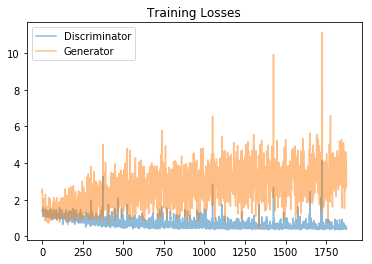

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

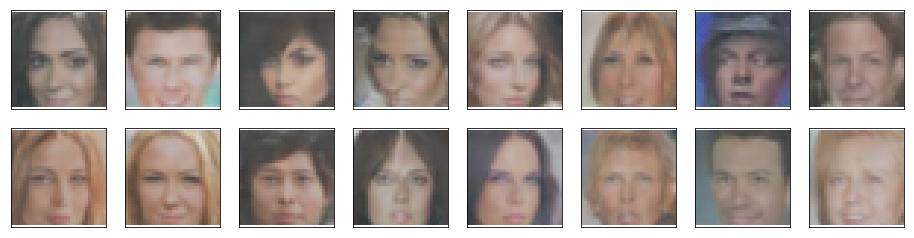

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
Since teh dataset is biased the generated images are biased, in order to have a better representation of overall human population the training dataset needs to be improved including images with faces of color, etc. In order to improve the resolution and detail training images with better resolution can be used but in that case teh network might be required to be deeper and numebr of epochs would be increased. In order to improve the results, I could train for a higher epochs value. Another improvement could be having a residual layers in between convolutional and deconvolutional layers. Also, I could add drop out to discriminator as suggested by one of the reviewers.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.